<a href="https://colab.research.google.com/github/akalpit23/Interpretable-ML/blob/main/Assignment-4/Assignment_04_Interpretable_ML_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #04



## Akalpit Dawkhar

### **Interpretable ML-2**

### Overview

# 1. Importing neccesarry libraries, loading and preprocessing the data. 

In [363]:
# !pip install skope-rules shap lime scikit-learn seaborn skope-rules matplotlib setuptools six rulefit --upgrade
# !pip install --upgrade imodels
# !pip install interpret
# !pip install collections
# !pip show imodels graphviz


In [364]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lime
import sklearn
import collections
import demo_helper
import six
import os
import graphviz
collections.Iterable = collections.abc.Iterable
sklearn.externals.six = six
from scipy.io import arff
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, precision_recall_curve, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler ,OneHotEncoder, label_binarize, KBinsDiscretizer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, precision_recall_curve, roc_auc_score
from sklearn.datasets import load_diabetes
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from sklearn import tree
from itertools import cycle
import skrules.skope_rules
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import six
from imodels import  RuleFitRegressor, BoostedRulesClassifier, GreedyRuleListClassifier, GreedyTreeClassifier, GreedyTreeRegressor
from rulefit import RuleFit
from skrules import SkopeRules
from skrules import SkopeRules as SkopeRulesClassifier
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())
from interpret.glassbox import APLRClassifier
from interpret import show


In [365]:
def patched_init(*args, **kwargs):
    """
    Patched __init__ method for BaggingClassifier in the skrules.skope_rules module.

    This patch modifies the constructor (__init__) of the BaggingClassifier class to ensure
    compatibility with updated scikit-learn or model APIs. Specifically, it renames the 
    'base_estimator' argument to 'estimator', as some versions of libraries may expect 
    'estimator' instead of 'base_estimator'.

    Parameters:
    *args: tuple
        Positional arguments that are passed to the original __init__ method of 
        BaggingClassifier.

    **kwargs: dict
        Keyword arguments that are passed to the original __init__ method of 
        BaggingClassifier. If 'base_estimator' is provided, it is renamed to 'estimator'
        before passing to the original __init__ method.

    Returns:
    object
        The initialized BaggingClassifier object after calling the original __init__ 
        with modified arguments, if applicable.

    Notes:
    ------
    This patch is useful for maintaining backward compatibility with older versions of 
    code or when there is a naming conflict in the API. It modifies the constructor at 
    runtime without directly altering the source code of the `imodels` or `skrules` library.
    """
    if 'base_estimator' in kwargs:
        kwargs['estimator'] = kwargs.pop('base_estimator')
    return original_init(*args, **kwargs)

original_init = skrules.skope_rules.BaggingClassifier.__init__
skrules.skope_rules.BaggingClassifier.__init__ = patched_init

In [366]:
def patch_estimator(cls):
    """
    Patched initialization method for BaggingClassifier in the skrules.skope_rules module.

    This function modifies the '__init__' method of the BaggingClassifier class to replace 
    the 'base_estimator' keyword argument with 'estimator' to maintain compatibility 
    with updated API changes or requirements in the 'skrules.skope_rules' package.

    Parameters:
    *args: tuple
        Positional arguments passed to the original __init__ method of BaggingClassifier.
        
    **kwargs: dict
        Keyword arguments passed to the original __init__ method of BaggingClassifier.
        If 'base_estimator' is present in the kwargs, it is replaced with 'estimator'.

    Returns:
    The result of calling the original __init__ method of BaggingClassifier with modified 
    arguments and keyword arguments.
    
    Notes:
    This patch is necessary because some versions of scikit-learn and other model 
    implementations may use 'estimator' instead of 'base_estimator'. This ensures 
    compatibility without modifying the underlying library directly.
    """
    original_init = cls.__init__
    def patched_init(*args, **kwargs):
        if 'base_estimator' in kwargs:
            kwargs['estimator'] = kwargs.pop('base_estimator')
        return original_init(*args, **kwargs)
    cls.__init__ = patched_init

patch_estimator(skrules.skope_rules.BaggingClassifier)
patch_estimator(skrules.skope_rules.BaggingRegressor)

In [367]:
# Load the diabetes dataset
diabetes = load_diabetes()

# Convert the continuous target to binary
y_median = np.median(diabetes.target)
y = (diabetes.target > y_median).astype(int)  # labels 0-1

# Prepare the feature data
X = diabetes.data.astype('float32')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75)  # split


In [368]:
# Convert to DataFrame
diabetes_df = pd.DataFrame(data=diabetes.data, columns=diabetes.feature_names)

# Print the first 5 rows
print(diabetes_df.head())

# Get the feature names
f_names = diabetes.feature_names

# Define the original feature names
o_names = ["age", "sex", "bmi", "bp", "tc", "ldl", "hdl", "tch", "ltg", "glu"]

        age       sex       bmi        bp        s1        s2        s3  \
0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2  0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
3 -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4  0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   

         s4        s5        s6  
0 -0.002592  0.019907 -0.017646  
1 -0.039493 -0.068332 -0.092204  
2 -0.002592  0.002861 -0.025930  
3  0.034309  0.022688 -0.009362  
4 -0.002592 -0.031988 -0.046641  


In [369]:
# Check the shape of your DataFrame
print(X_train.shape)

# Check the column names of your DataFrame
print(diabetes_df.columns)

(110, 10)
Index(['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6'], dtype='object')


# 2. RuleFit rule sit 

In [370]:
# Initialize the RuleFitRegressor
rf = RuleFitRegressor(max_rules=10, memory_par=0.01, tree_size=4, lin_standardise=True)

# Fit the model to your data
rf.fit(X_train, y_train, feature_names=o_names)

RuleFitRegressor(max_rules=10)

In [371]:
# Use the model to make predictions
predictions = rf.predict(X_test)

In [372]:
rule_df = rf.visualize()
rule_df

,rule,coef
12,age > -0.08725 and bp <= 0.03392 and glu <= 0.02585,-0.01
15,bmi > -0.02722 and hdl <= 0.02655 and ltg > -0.0385,0.22
14,ldl <= 0.0372 and hdl <= 0.02471 and ltg > -0.06032,0.01
11,tc > -0.03941 and ltg <= 0.022,-0.03
10,bp <= 0.03564 and hdl > -0.00843,-0.07
17,bmi > -0.0283 and bp > -0.00223,0.01
13,hdl <= -0.00843 and glu > -0.02386,0.12
18,hdl <= -0.00843 and glu > -0.02593,0.00
16,bmi > 0.01266 and glu > -0.03007,0.14
19,bmi > 0.01427 and glu > -0.028,0.00


In [373]:
# Inspect and print the rules
print('Rulefit visualization:')
rules = rf._get_rules()
rules = rules[rules.coef != 0].sort_values("support", ascending=False)
display(rules[['rule', 'coef', 'support']].style.background_gradient(cmap='Blues'))

Rulefit visualization:


,rule,coef,support
12,age > -0.08725 and bp <= 0.03392 and glu <= 0.02585,-0.013182,0.572727
15,bmi > -0.02722 and hdl <= 0.02655 and ltg > -0.0385,0.224054,0.536364
14,ldl <= 0.0372 and hdl <= 0.02471 and ltg > -0.06032,0.010399,0.527273
11,tc > -0.03941 and ltg <= 0.022,-0.027845,0.481818
10,bp <= 0.03564 and hdl > -0.00843,-0.068491,0.390909
17,bmi > -0.0283 and bp > -0.00223,0.014687,0.390909
13,hdl <= -0.00843 and glu > -0.02386,0.118142,0.381818
18,hdl <= -0.00843 and glu > -0.02593,0.002056,0.381818
16,bmi > 0.01266 and glu > -0.03007,0.135937,0.336364
19,bmi > 0.01427 and glu > -0.028,0.004588,0.336364


In [374]:
# Calculate the mean absolute error
mae = mean_absolute_error(y_test, predictions)

# Calculate the mean squared error
mse = mean_squared_error(y_test, predictions)

# Calculate the R-squared score
r2 = r2_score(y_test, predictions)

# Print the metrics
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R2 Score: {r2}')

MAE: 0.4017091807245696
MSE: 0.203048457594391
R2 Score: 0.18780616962243601


# 3. Greedy Rule List Classifier 

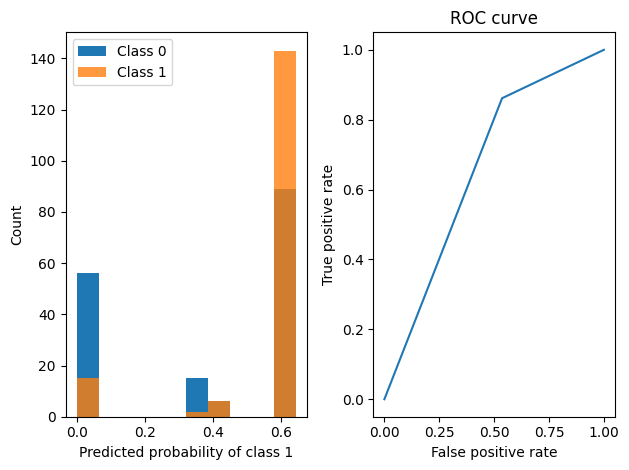

GreedyRuleListClassifier()

In [375]:
# fit a greedy rule list
greedy_model = GreedyRuleListClassifier()
greedy_model.fit(X_train, y_train, feature_names=o_names)  # stores into m.rules_
probability_grlc = greedy_model.predict_proba(X_test)

# look at prediction breakdown
demo_helper.viz_classification_preds(probability_grlc, y_test)

m

# 4. Automatic Piecewise Linear Regression (APLR) (Sub-section of Tree GAM)

In [376]:
seed = 42
np.random.seed(seed)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=seed
)

aplr = APLRClassifier(random_state=seed)
aplr.fit(X_train, y_train, X_names=o_names)

auc = roc_auc_score(y_test, aplr.predict_class_probabilities(X_test)[:, 1])
print("AUC: {:.3f}".format(auc))

AUC: 0.804


In [377]:
show(aplr.explain_local(X_test[:5], y_test[:5]))

# 5. Greedy Tree Regressor 

In [378]:
# Fit the model to the training data
gtr_model = GreedyTreeRegressor()
gtr_model.fit(X_train, y_train)

# Get the predictions
y_pred_gtr = gtr_model.predict(X_test)

# Calculate the accuracy
accuracy_greedytree = accuracy_score(y_test, y_pred_gtr)
print(f"GreedyTreeRegressor: {accuracy_greedytree}")

GreedyTreeRegressor: 0.6741573033707865


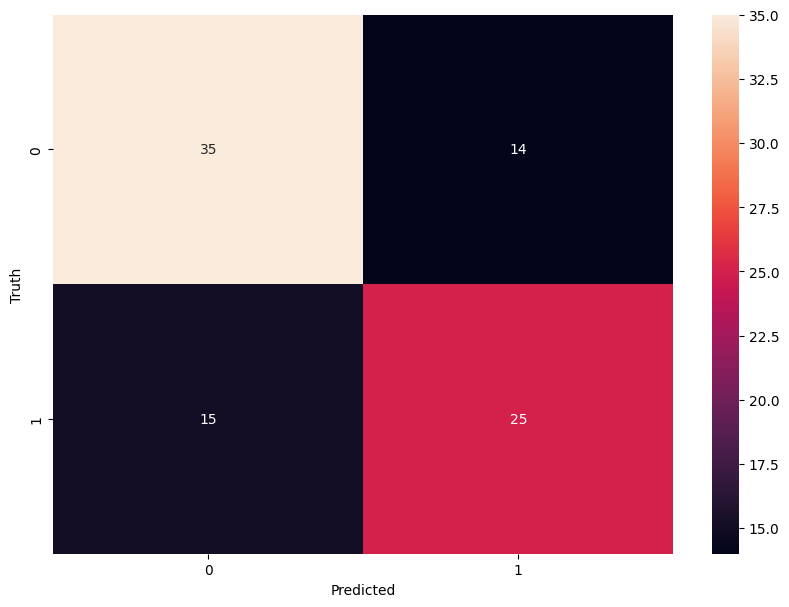

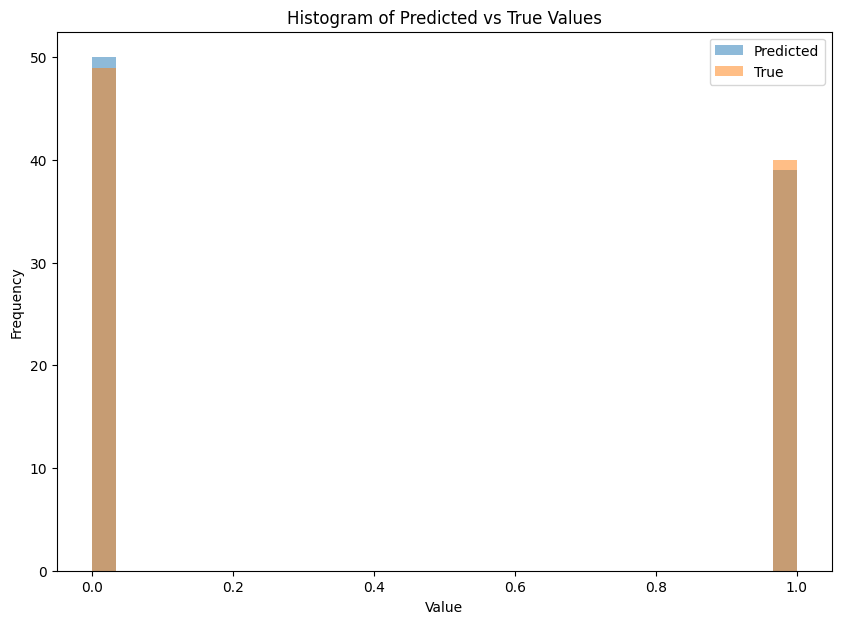

In [379]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_gtr)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

plt.figure(figsize=(10, 7))

# Plot a histogram of the predicted values
plt.hist(y_pred_gtr, bins=30, alpha=0.5, label='Predicted')

# Plot a histogram of the true values
plt.hist(y_test, bins=30, alpha=0.5, label='True')

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Histogram of Predicted vs True Values')
plt.show()

# 6. Refrences:


*   https://github.com/csinva/imodels/tree/master?tab=readme-ov-file 
*   https://github.com/interpretml/interpret?tab=readme-ov-file
*   https://github.com/christophM/rulefit